In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.1.0


### 자동차 연비 예측하기 : 회귀 

회귀는 가격이나 확률 같이 연속된 출력 값을 예측하는 것이 목적임.  
분류는 여러개의 클래스 중 하나의 클래스를 선택하는 것이 목적임.

Auto MPG 데이터셋을 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 모델을 만들 것.  
이 기간에는 출시된 자동차 정보를 모델에 제공함. 이 정보에는 실렌더 수, 배기량, 마력, 공차 중량 같은 속성이 포함됨.




In [2]:
import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras import layers

import pandas as pd
import seaborn as sns

#### Auto MPG 데이터셋

이 데이터셋은 UCI 머신 러닝 저장소에서 다운로드할 수 있습니다.

##### 데이터 구하기


In [3]:
dataset_path = keras.utils.get_file('auto-mpg.data', "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\jye12\\.keras\\datasets\\auto-mpg.data'

판다스를 사용하여 데이터 읽기.

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names= column_names,
                         na_values = '?', comment= '\t', sep = ' ', skipinitialspace=True )

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


##### 데이터 정제하기
이 데이터셋은 일부 데이터가 누락되어 있습니다.


In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

문제를 간단하게 만들기 위해서 누락된 행을 삭제함.

In [6]:
dataset = dataset.dropna()

'Origin' 열은 수치형이 아니고 범주형이므로, 원-핫 인코딩으로 변환함.

In [7]:
origin = dataset.pop('Origin')

In [8]:
dataset['USA'] = (origin==1) * 1.0
dataset['Europe'] = (origin ==2) *2.0
dataset['Japan'] = (origin ==3) *1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,2.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


##### ***데이터셋을 훈련 세트와 테스트 세트로 분할하기***

이제 데이터를 훈련 세트와 테스트 세트로 분할함.

테스트 세트는 모델을 최종적으로 평가할 떄 사용함.

In [9]:
train_dataset = dataset.sample(frac =0.8 , random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

##### 데이터 조사하기

훈련 세트에서 몇 개의 열을 선택해 산점도 행렬을 만들어 살펴 보겠습니다.

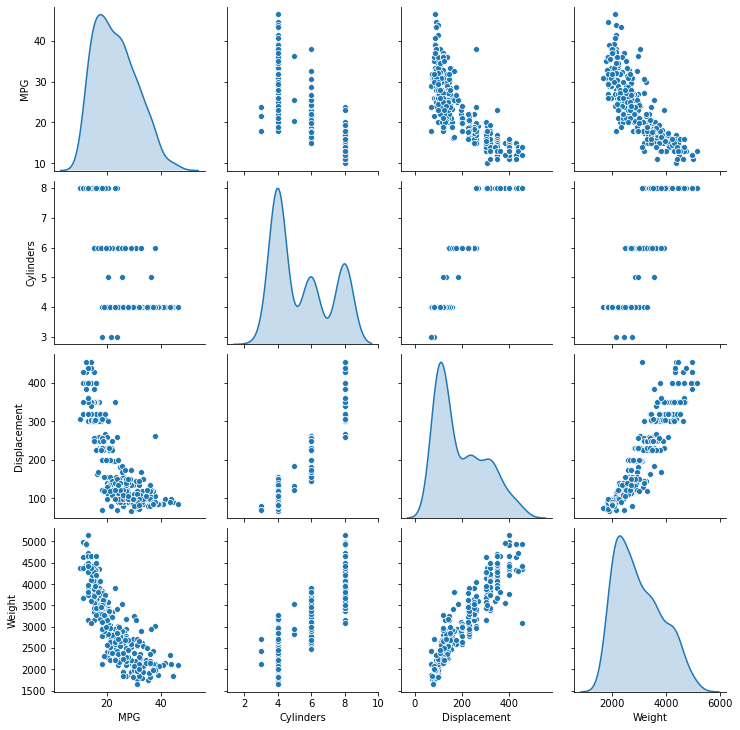

In [10]:
sns.pairplot(train_dataset[["MPG","Cylinders","Displacement","Weight"]],diag_kind = 'kde')

전반적인 통게도 학인해 보자.

In [11]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.356688,0.766826,0.0,0.00,0.0,0.00,2.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


##### 특성과 레이블 분리하기

특성에서 타깃 값 또는 "레이블"을 분리함. 이 레이블을 예측하기 위해 모델을 훈련시킬 것임.

In [12]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

##### 데이터 정규화
위 train_stats 통계를 다시 살펴보고 각 특성의 범위가 얼마나 다른지 확인해 보자.

특성의 스케일과 범위가 다르면 정규화하는 것을 권장 >> 특정 변수에 의존성을 벗어나 모델을 성능 상승 가능

ps. 의도적으로 훈련 세트만 사용하여 통계치를 생성함. 이 통계는 테스트 세트를 정규화할 떄에도 사용됨.  
이는 테스트 세트를 모델이 훈련에 사용했던 것과 동일한 분포로 투영하기 위해서 임.

In [13]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

정규화된 데이터를 모두 사용하여 모델을 훈련함.

ps. 여기에서 입력 데이터를 정규화하기 위해 사용한 통계치(평균과 표준편차)는 원-핫 인코딩과 마찬가지로 모델에 주입되는 모든 데이터에 적용되어야 함.  
여기에는 테스트 세트는 물론 모델이 실전에 투입되어 얻은 라이브 데이터도 포함됨.

#### 모델 

##### 모델 만들기

모델을 구성해 보자. 여기에서는 두 개의 완전 연결(densely connected) 은닉층으로 Sequential 모델을 만들겠음.  
출력 층은 하나의 연속적인 값을 반환함. 나중에 두 번째 모델을 만들기 쉽도록 build_model 함수로 모델 구성 단계를 감싸겠습니다.

In [15]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss ='mse',
                 optimizer = optimizer,
                 metrics =['mae','mse'])
    return model

In [16]:
model = build_model()

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


모델을 한번 실행해 보자. 훈련 세트에서 10 샘플을 하나의 배치로 만들어 model.predict 메서드를 호출해 봄.

In [18]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.3668778 ],
       [0.08829235],
       [0.35096326],
       [0.12856258],
       [0.32445136],
       [0.02179613],
       [0.32945967],
       [0.45029336],
       [0.07757625],
       [0.14282611]], dtype=float32)

제대로 작동하는 것 같네요. 결괏값의 크기와 타입이 기대했던 대로임.

##### 모델 훈련
이 모델을 1000번의 에포크동안 훈련함. 훈련 정확도의 검증 정확도는 history 객체에 기록됨.

In [20]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시함.
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100==0:
            print('')
        print('.', end= '')
        
EPOCHS = 1000
    
history = model.fit(
normed_train_data, train_labels,
epochs = EPOCHS , validation_split = 0.2, verbose =0, 
callbacks =[PrintDot()])    


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

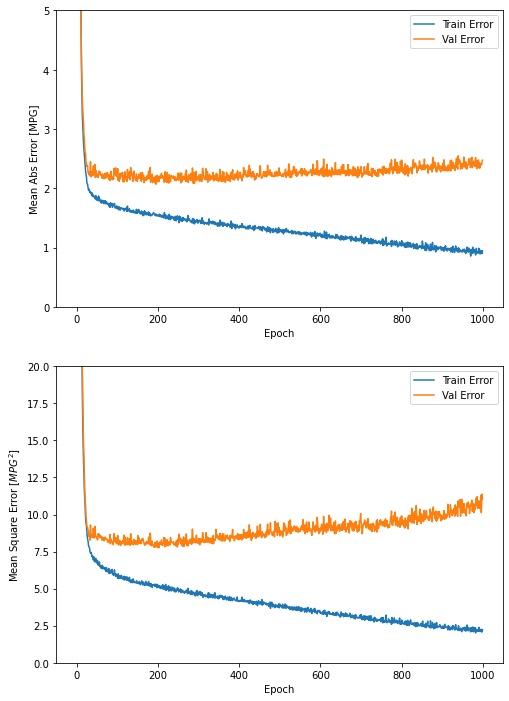

In [23]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=(8,12))
    
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
            label= 'Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label ='Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'] , hist['mse'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()
    
plot_history(history)

이 그래프를 보면 수 백번 에포크를 진행한 이후에는 모델이 거의 향상되지 않는 것을 확인.  
model.fit 메서드를 수정하여 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 만들어 보자.  
에포크마다 훈련 상태를 점검하기 위해 EarlyStopping 콜백을 사용하겠음. 지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춤.


..................................................

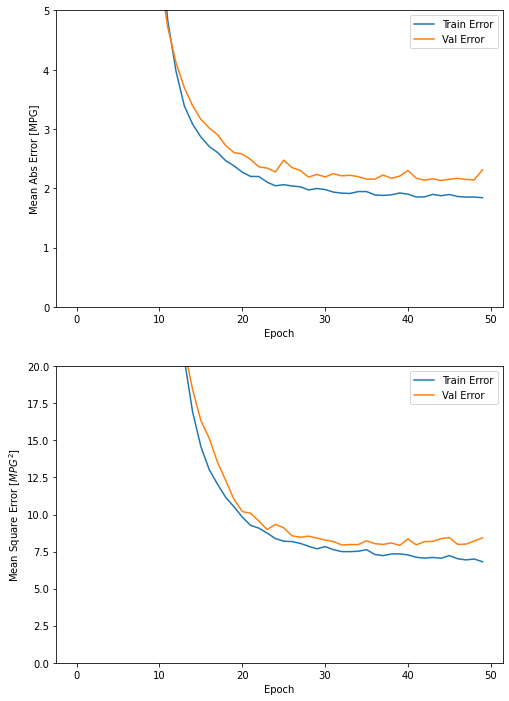

In [26]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience =10)

history = model.fit(normed_train_data, train_labels, epochs = EPOCHS,
                   validation_split = 0.2, verbose =0, callbacks= [early_stop, PrintDot()])

plot_history(history)

이 그래프를 보면 검증 세트의 평균 오차가 약 +/- 2 MPG 임. 

모델을 훈련할 때 사용하지 않았던 테스트 세트에서 모델의 성능을 확인해보죠.  
이를 통해 모델이 실전에 투입되었을 때 모델의 성능을 짐작할 수 있음.

In [28]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차 : {:5.2f}".format(mae))

78/78 - 0s - loss: 6.0851 - mae: 1.8148 - mse: 6.0851
테스트 세트의 평균 절대 오차 :  1.81


##### 예측
마지막으로 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측해 보겠음.

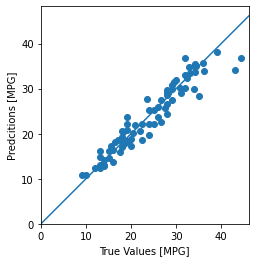

In [30]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predcitions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100,100], [-100,100])

모델이 꽤 잘 예측한 것 같음. 오차의 분포를 살펴 보자.

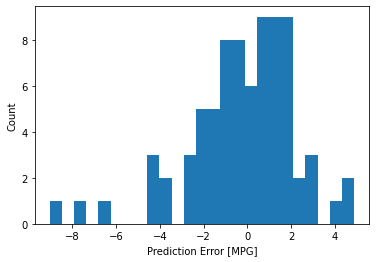

In [31]:
error = test_predictions - test_labels
plt.hist(error, bins =25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

결론
이 노트북은 회귀 문제를 위한 기법을 소개합니다.

- 평균 제곱 오차(MSE)는 회귀 문제에서 자주 사용하는 손실 함수입니다(분류 문제에서 사용하는 손실 함수와 다릅니다).
- 비슷하게 회귀에서 사용되는 평가 지표도 분류와 다릅니다. 많이 사용하는 회귀 지표는 평균 절댓값 오차(MAE)입니다.
- 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야 합니다.
- 훈련 데이터가 많지 않다면 과대적합을 피하기 위해 은닉층의 개수가 적은 소규모 네트워크를 선택하는 방법이 좋습니다.
- 조기 종료(Early stopping)은 과대적합을 방지하기 위한 좋은 방법입니다.